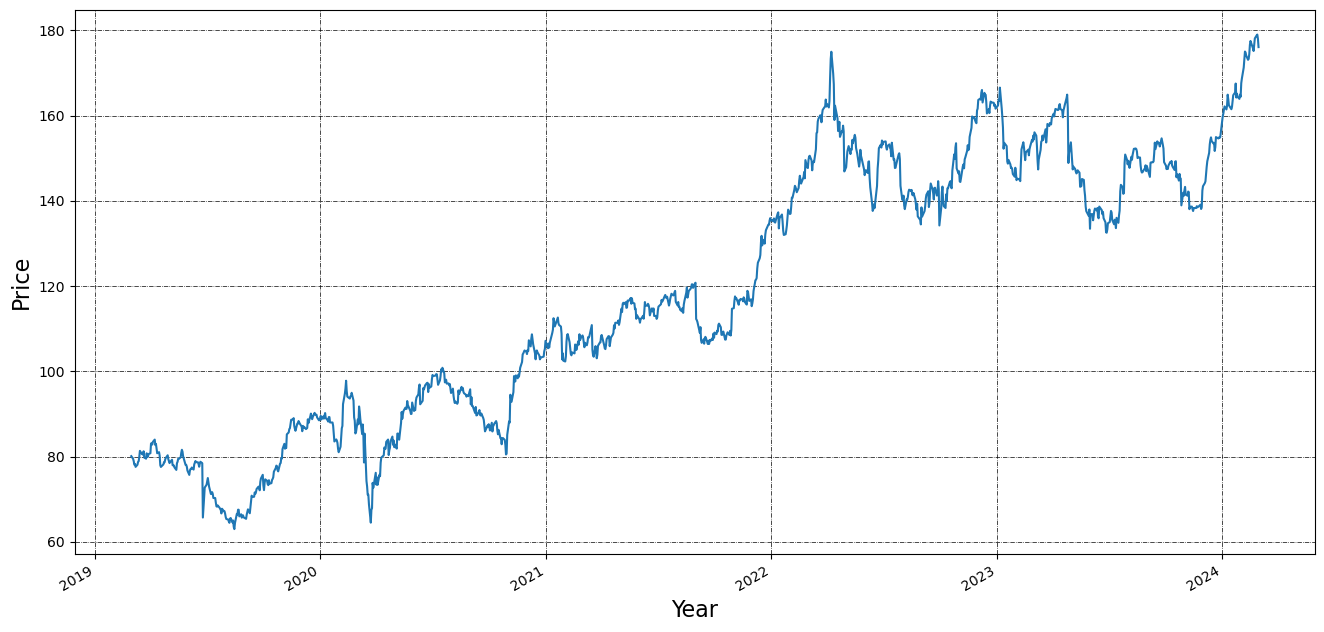

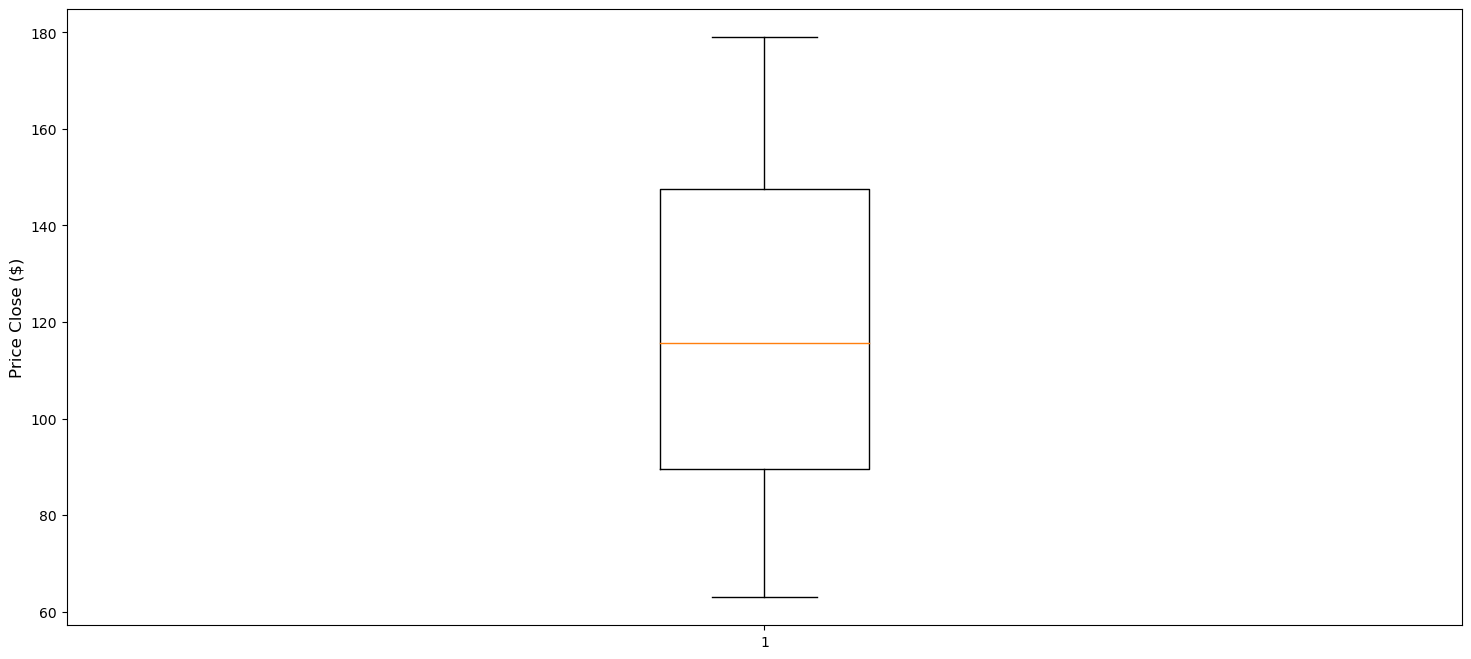

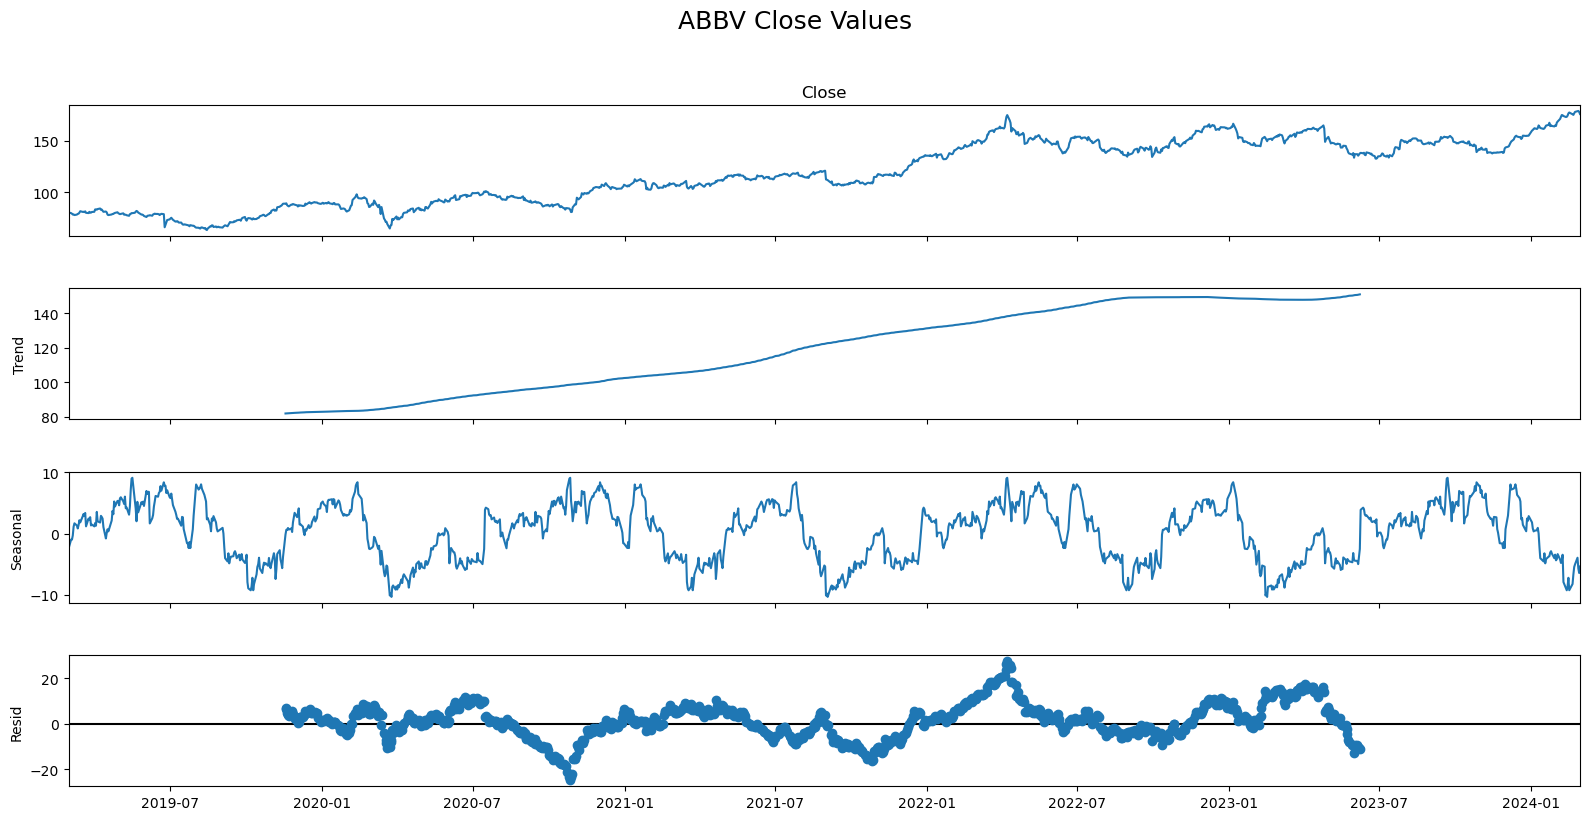

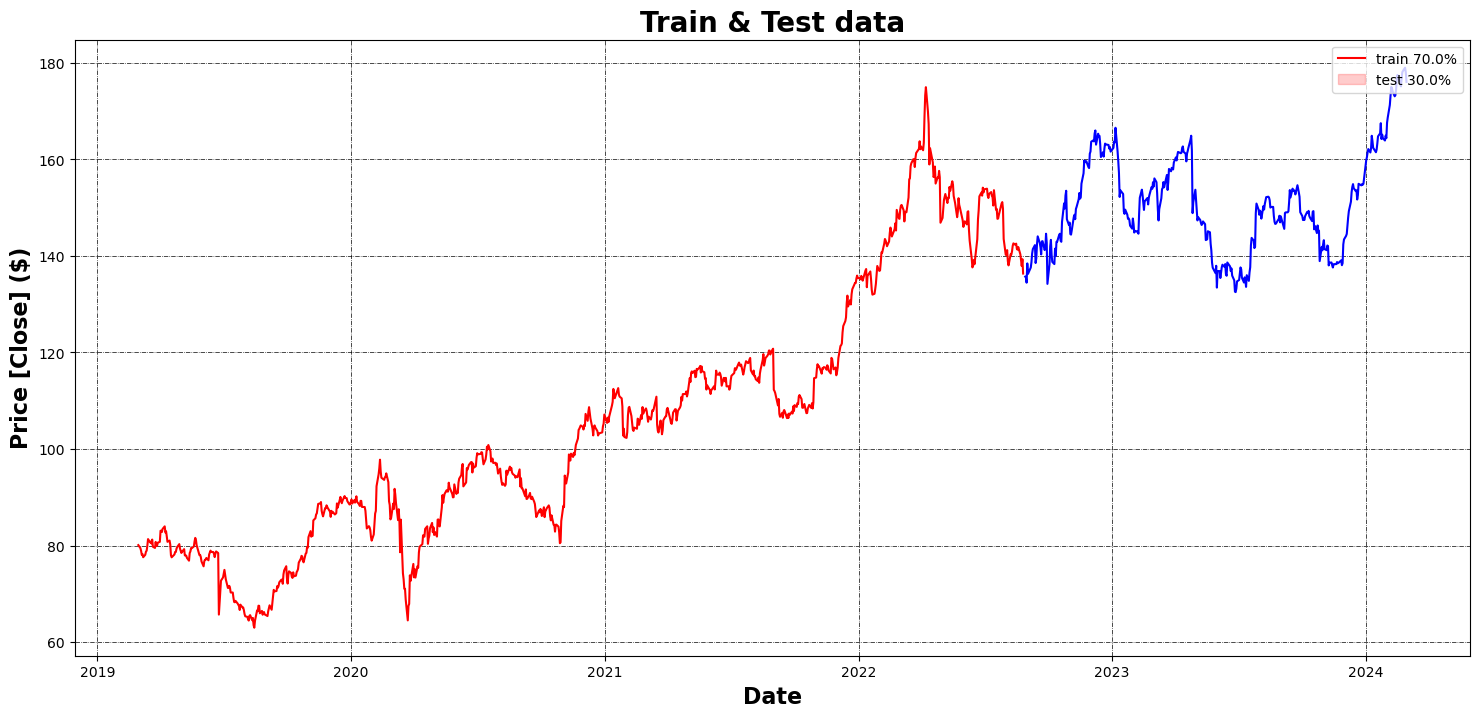

Tập train:
count    881.000000
mean     104.569148
std       25.908073
min       62.980000
25%       83.959999
50%      102.480003
75%      116.870003
max      174.960007
Name: Close, dtype: float64

Tập test:
count    378.000000
mean     150.666852
std       10.301471
min      132.509995
25%      142.957500
50%      149.260002
75%      157.979999
max      178.990005
Name: Close, dtype: float64
Epoch 1/100, Loss: 0.10043178828289875
Epoch 2/100, Loss: 0.01831437049147028
Epoch 3/100, Loss: 0.0070282477849664595
Epoch 4/100, Loss: 0.0061607388600420495
Epoch 5/100, Loss: 0.006948589418943112
Epoch 6/100, Loss: 0.005669489968568087
Epoch 7/100, Loss: 0.0049907647413559835
Epoch 8/100, Loss: 0.004027712866305732
Epoch 9/100, Loss: 0.0037262451727516376
Epoch 10/100, Loss: 0.004657368686121817
Epoch 11/100, Loss: 0.004012403006737049
Epoch 12/100, Loss: 0.004675724203340136
Epoch 13/100, Loss: 0.004234597982408909
Epoch 14/100, Loss: 0.005276297022087069
Epoch 15/100, Loss: 0.0040143132120

AttributeError: 'ResCNN_LSTM' object has no attribute 'predict'

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import rcParams
# Import necessary libraries
from tsai.all import *
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.utils import *
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Graphing support library
import matplotlib.pyplot as plt

import joblib
from pylab import rcParams
from random import randrange
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose

# Load data
df = pd.read_csv('ABBV-AbbVie.csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

# Select the Close column as the dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))
data_scaled = np.squeeze(data_scaled)

# Plot the Close price
df['Close'].plot(figsize=(16, 8))
plt.ylabel('Price', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

plt.figure(figsize=(18, 8))
plt.boxplot(df['Close'])
plt.ylabel("Price Close ($)", fontsize=12)
plt.show()

rcParams['figure.figsize'] = 16, 8
decomposition = seasonal_decompose(df['Close'], model='additive', period=365)
fig = decomposition.plot()
fig.suptitle('ABBV Close Values', fontsize=18, y=1.02)
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.show()

size = 0.7  # Chia train/test
size_train = int(len(df) * size)
fig, ax = plt.subplots(figsize=(18, 8)) # 4.5, 2
sns.lineplot(x=df.index[:size_train], y=df['Close'][:size_train], color='red')
sns.lineplot(x=df.index[size_train:], y=df['Close'][size_train:], color='blue')
ax.set_title('Train & Test data', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price [Close] ($)', fontsize=16, fontdict=dict(weight='bold'))
plt.legend(loc='upper right', labels=('train ' + str(size*100) + '%', 'test ' + str(100 - size*100) + '%'))
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

print("Tập train:")
print(df[:size_train]['Close'].describe())
print("")
print("Tập test:")
print(df[size_train:]['Close'].describe())

class ConvBlock(nn.Module):
    def __init__(self, ni, nf, ks, act=nn.ReLU, coord=False, separable=False, zero_norm=False):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act() if act is not None else None
        self.coord = coord

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.act is not None:
            x = self.act(x)
        return x

class ConvBN(nn.Module):
    def __init__(self, ni, nf, ks, coord=False, **kwargs):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, padding=ks//2, **kwargs)
        self.bn = nn.BatchNorm1d(nf)
        self.coord = coord

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class _ResCNNBlock(nn.Module):
    def __init__(self, ni, nf, kss=[7, 5, 3], coord=False, separable=False, zero_norm=False):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0], coord=coord, separable=separable)
        self.convblock2 = ConvBlock(nf, nf, kss[1], coord=coord, separable=separable)
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None, coord=coord, separable=separable, zero_norm=zero_norm)
        self.shortcut = ConvBN(ni, nf, 1, coord=coord)
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = x + self.shortcut(res)
        x = self.act(x)
        return x

class ResCNN(nn.Module):
    def __init__(self, c_in, c_out, coord=False, separable=False, zero_norm=False):
        super().__init__()
        nf = 64
        self.block1 = _ResCNNBlock(c_in, nf, kss=[7, 5, 3], coord=coord, separable=separable, zero_norm=zero_norm)
        self.block2 = ConvBlock(nf, nf * 2, 3, coord=coord, separable=separable, act=nn.LeakyReLU)
        self.block3 = ConvBlock(nf * 2, nf * 4, 3, coord=coord, separable=separable, act=nn.PReLU)
        self.block4 = ConvBlock(nf * 4, nf * 2, 3, coord=coord, separable=separable, act=nn.ELU)


        self.gap = nn.AdaptiveAvgPool1d(1)
        self.lin = nn.Linear(nf * 2, c_out)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x).squeeze(-1)
        return self.lin(x)

class ResCNN_LSTM(nn.Module):
    def __init__(self, c_in, c_out, hidden_dim, num_layers, coord=False, separable=False, zero_norm=False):
        super().__init__()
        self.ResCNN = ResCNN(c_in, hidden_dim, coord=coord, separable=separable, zero_norm=zero_norm)
        self.LSTM = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, c_out)

    def forward(self, x):
        x = self.ResCNN(x)
        x, _ = self.LSTM(x.unsqueeze(0))
        x = self.fc(x.squeeze(0))
        return x

# Chia dữ liệu thành các cặp input-output
X = []
y = []
day_in = 50 # Số lượng input ngày khi đi vào model
day_out = 30 # Số lượng ngày dự đoán tiếp theo
for i in range(len(data_scaled) - (day_in + day_out)):
    X.append(data_scaled[i:i+day_in])
    y.append(data_scaled[i+day_in:i+day_out+day_in])

# Chia dữ liệu thành tập train và test
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Chuyển dữ liệu thành tensor và tạo DataLoader
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1), torch.tensor(y_train, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1), torch.tensor(y_test, dtype=torch.float32))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Khởi tạo model và optimizer
model = ResCNN_LSTM(day_in, day_out, 64, 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện model
num_epoch = 100
for epoch in range(num_epoch):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = nn.MSELoss()(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {epoch_loss/len(train_loader)}")

# # Dự đoán trên tập test
# model.eval()
# test_predictions = []
# with torch.no_grad():
#     for batch_X, batch_y in test_loader:
#         output = model(batch_X)
#         test_predictions.append(output.numpy())
# test_predictions = np.concatenate(test_predictions, axis=0)

# # Example code to align predictions with actual values
# actual_values = df_Close['Close'][size_train+day_in:size_train+day_in+len(test_predictions_inv)].values
# # Ensure actual_values and test_predictions_inv have the same length
# test_predictions_inv = model.predict(test_data)  # Adjust according to your model and data

# # Now calculate metrics
# mae = mean_absolute_error(actual_values, test_predictions_inv)
# mse = mean_squared_error(actual_values, test_predictions_inv)
# r2 = r2_score(actual_values, test_predictions_inv)

# rmse = np.sqrt(mse)
# mape = mean_absolute_percentage_error(actual_values, test_predictions_inv)

# # In các chỉ số hiệu suất
# print(f"MAE: {mae}")
# print(f"MSE: {mse}")
# print(f"R2: {r2}")
# print(f"RMSE: {rmse}")
# print(f"MAPE: {mape}")

# Vẽ biểu đồ kết quả dự đoán và giá trị thực
plt.figure(figsize=(16, 8))
plt.plot(actual_values, label='Actual Values')
plt.plot(test_predictions_inv, label='Predicted Values')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Values')
plt.show()

# Dự đoán 30 ngày tiếp theo
last_sequence = torch.tensor(data_scaled[-day_in:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
future_predictions = []
# Dự đoán trên tập test
model.eval()
test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = model(batch_X)
        test_predictions.append(output.numpy())
test_predictions = np.concatenate(test_predictions, axis=0)

# Example code to align predictions with actual values
actual_values = df_Close['Close'][size_train+day_in:size_train+day_in+len(test_predictions)].values

# Now calculate metrics
mae = mean_absolute_error(actual_values, test_predictions)
mse = mean_squared_error(actual_values, test_predictions)
r2 = r2_score(actual_values, test_predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual_values, test_predictions)

# In các chỉ số hiệu suất
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Vẽ biểu đồ kết quả dự đoán và giá trị thực
plt.figure(figsize=(16, 8))
plt.plot(actual_values, label='Actual Values')
plt.plot(test_predictions, label='Predicted Values')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Values')
plt.show()